# Model 1 - Horizontal stratigraphic

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [2]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")


In [4]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [34]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}

geo_data.set_colors(colormodel)

cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

geo_data.formations

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [35]:
geo_data.set_colors(colormodel)

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [36]:
cmap.colors

['#0057e7', '#d62d20', '#ffa700']

In [8]:
#%matplotlib inline
#gp.get_sequential_pile(geo_data)

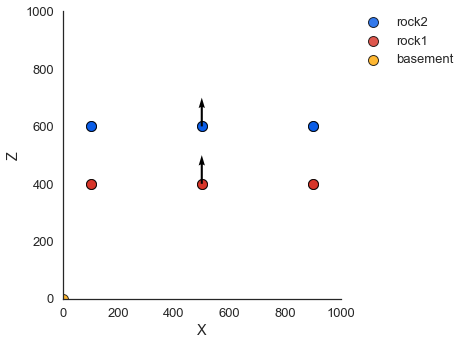

In [9]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [10]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '6944')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\Jan\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.6.4-64\lock_dir


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [11]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


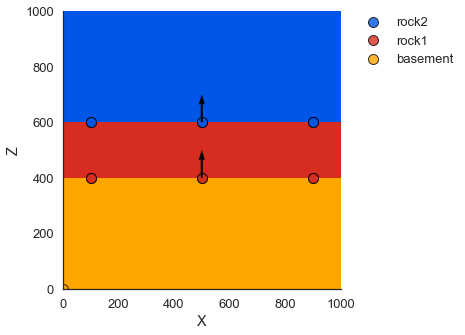

In [39]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model1_pure', edgecolor='black')

In [13]:
import gempy.utils.Kriging_Jan as krige

In [14]:
d = {'X': [600, 600], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  600  10  500        20
1  600  10  500        20


In [15]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='deformed')

initializing: 0.005997419357299805
distance precalculation: 40.15009593963623
submatrix extraction: 0.018990755081176758
distance Matrices: 0.435776948928833
kriging calculation: 0.7520852088928223
Negative Variances: 0
Out of: 4001


In [16]:
coord3d_aux = test.grid_dataframe.values
coord3d_aux = np.delete(coord3d_aux, 3, 1)
coord3d_aux = np.swapaxes(coord3d_aux, 0,1) # for plotting later

contr_coord = test.control_coord
contr_coord = np.delete(contr_coord, (0), axis=0)
contr_coord = np.swapaxes(contr_coord, 0,1)

import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

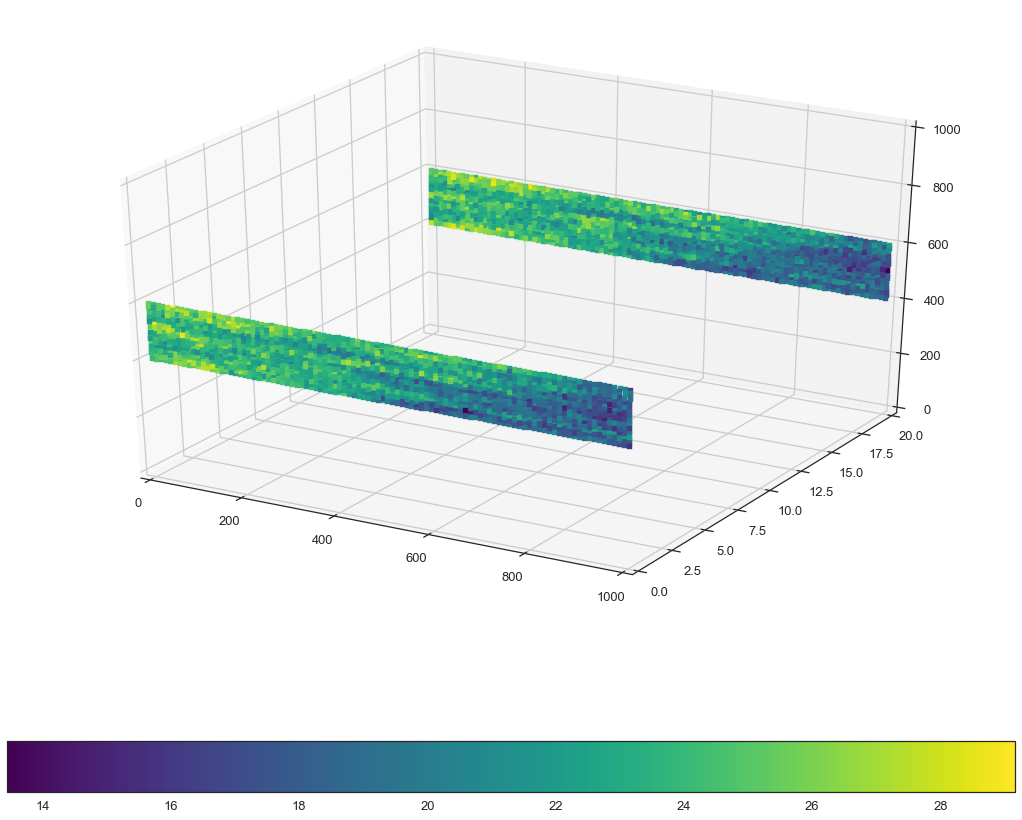

In [17]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,1000)
ax.axes.set_xlim3d(0,1000)
ax.axes.set_ylim3d(0,20)
# a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=25, marker=',', cmap='viridis', norm=norm, alpha=1)
a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=25, marker=',', cmap='viridis', alpha=1)

fig.colorbar(a, orientation='horizontal')

In [18]:
print(lith_block.shape)

(2, 20000)


In [19]:
print(test.result_coord.shape)
print(test.kriging_result[1])
geo_data.resolution

(5, 4001)
[20.         20.         25.51913672 ... 21.69527024 18.40115549
 24.33869977]


array([100,   2, 100])

In [20]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]


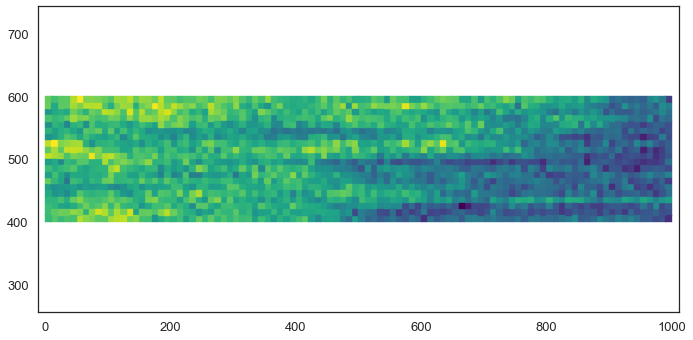

In [21]:
fig = plt.figure(figsize=(10, 5))

a = plt.scatter(x=combined_cut[:,0], y=combined_cut[:,1], c=combined_cut[:,2], s=40, marker=',',cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.tight_layout()

In [22]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=50, resY=50):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

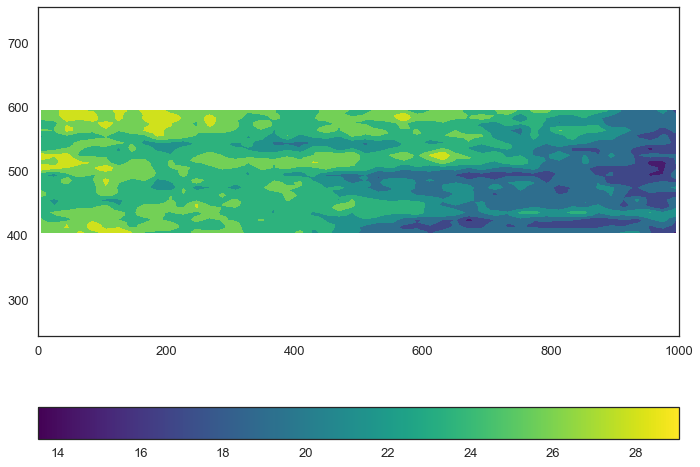

In [23]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

fig = plt.figure(figsize=(10, 7))

plt.contourf(X, Y, Z, cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.colorbar(a, orientation='horizontal')
fig.tight_layout()

In [24]:
# Sampling
def random_sampling(data):
    #print(len(data))
    rand_pos = np.random.randint(0,len(data),100)
    #print(rand_pos)
    #print(rand_pos.shape)
    samples = data[rand_pos]
    return samples

In [25]:
samples = random_sampling(combined)

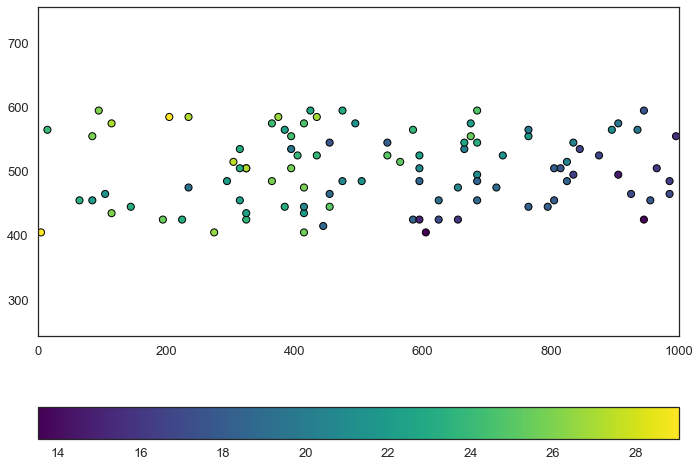

In [26]:
fig = plt.figure(figsize=(10, 7))

plt.scatter(x=samples[:,0], y=samples[:,2], c=samples[:,3], s=50, cmap='viridis', linewidths=1, edgecolors='black')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.colorbar(a, orientation='horizontal')
fig.tight_layout()

In [27]:
d = {'X': samples[:,0], 'Y': samples[:,1], 'Z': samples[:,2], 'Property': samples[:,3]}
data_field = pd.DataFrame(data=d)
#print(data_field)

In [28]:
simulation = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian')

initializing: 0.019988298416137695
distance precalculation: 0.20787835121154785
submatrix extraction: 0.011000394821166992
distance Matrices: 0.4317917823791504
kriging calculation: 0.7255575656890869
Negative Variances: 0
Out of: 4001


In [29]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

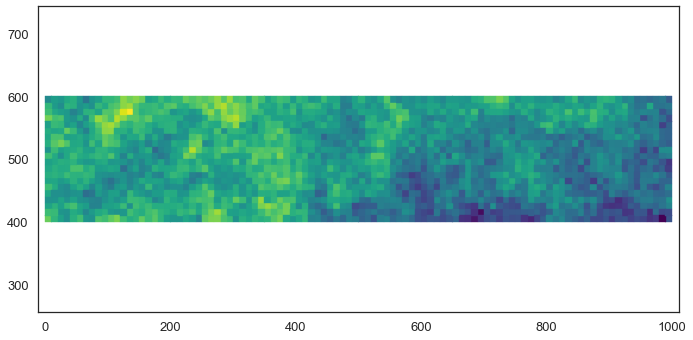

In [30]:
fig = plt.figure(figsize=(10, 5))

a = plt.scatter(x=combined_cut[:,0], y=combined_cut[:,1], c=combined_cut[:,2], s=40, marker=',',cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.tight_layout()

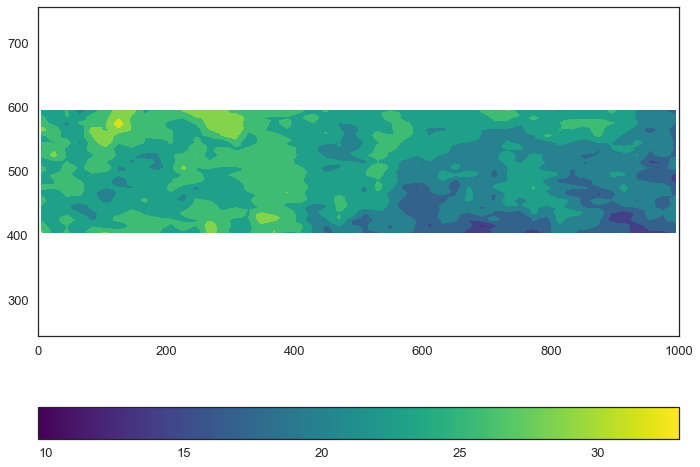

In [31]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

fig = plt.figure(figsize=(10, 7))

plt.contourf(X, Y, Z, cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.colorbar(a, orientation='horizontal')
fig.tight_layout()